# 利用MindQuantum解决组合优化问题

In [1]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
Looking in links: https://obs-workspace-20180810.obs.cn-north-1.myhuaweicloud.com/pypi/index.html


In [2]:
import networkx as nx

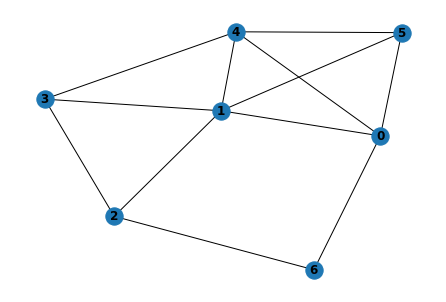

In [3]:
g = nx.gnm_random_graph(7, 12, seed=42)
nx.draw(g,with_labels=True, font_weight='bold')

In [4]:
print(list(g.edges))

[(0, 5), (0, 4), (0, 1), (0, 6), (1, 2), (1, 4), (1, 3), (1, 5), (2, 6), (2, 3), (3, 4), (4, 5)]


## nx库中的解法

In [5]:
cut, partition = nx.algorithms.approximation.one_exchange(g)
print(cut, partition)

9 ({1, 4, 6}, {0, 2, 3, 5})


## Try to solve by yourself

In [6]:
def solution(edges):
    pass

In [7]:
my_cut = solution(list(g.edges))
print(f'I get {my_cut} cuts')

I get None cuts


## QAOA

In [8]:
from mindquantum import *

In [9]:
depth = 5
ansatz = MaxCutAnsatz(list(g.edges), depth)

ham = ansatz.hamiltonian
circuit = ansatz.circuit
circuit

q0: ──H────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────RX(alpha_3)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ(beta_4)────ZZ(beta_4)────ZZ(beta_4)────ZZ(beta_4)────RX(alpha_4)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │             │             │             │                                                                                                                                                 │             │             │             │                                                                                                                                                 │             │             │             │                                                                                                                                                 │             │             │             │                                                                                                                                                 │             │             │             │                                                                                                                                           
q1: ──H────────┼─────────────┼─────────ZZ(beta_0)────────┼──────────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────ZZ(beta_0)────RX(alpha_0)────────────────────────────────────────────────────────────────────┼─────────────┼─────────ZZ(beta_1)────────┼──────────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────ZZ(beta_1)────RX(alpha_1)────────────────────────────────────────────────────────────────────┼─────────────┼─────────ZZ(beta_2)────────┼──────────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────ZZ(beta_2)────RX(alpha_2)────────────────────────────────────────────────────────────────────┼─────────────┼─────────ZZ(beta_3)────────┼──────────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────ZZ(beta_3)────RX(alpha_3)────────────────────────────────────────────────────────────────────┼─────────────┼─────────ZZ(beta_4)────────┼──────────ZZ(beta_4)────ZZ(beta_4)────ZZ(beta_4)────ZZ(beta_4)────RX(alpha_4)──────────────────────────────────────────────────────────────
               │             │                           │              │             │             │             │                                                                                        │             │                           │              │             │             │             │                                                                                        │             │                           │              │             │             │             │                                                                                        │             │                           │              │             │             │             │                                                                                        │             │                           │              │             │             │             │                                                                                  
q2: ──H────────┼─────────────┼───────────────────────────┼──────────ZZ(beta_0)────────┼─────────────┼─────────────┼──────────ZZ(beta_0)─────ZZ(beta_0)────RX(alpha_0)───────────────────────────────────

In [10]:
sim = Simulator('projectq', circuit.n_qubits)
grad_ops = sim.get_expectation_with_grad(Hamiltonian(-ham), circuit)

In [11]:
import numpy as np

grad_ops(np.random.random(size=len(circuit.params_name)))

(array([[-6.23877832+9.87388717e-18j]]),
 array([[[-0.24010671+0.j,  0.36403282+0.j, -0.60722775+0.j,
           0.13633899+0.j, -0.39841083+0.j, -0.32306245+0.j,
           0.47259835+0.j, -0.8125774 +0.j,  1.14310793+0.j,
          -0.79756074+0.j]]]))

### 利用`scipy`的优化器进行优化

In [12]:
from scipy.optimize import minimize

def fun(x):
    f, g = grad_ops(x)
    print(f"Cut value: {-f.real[0, 0]}")
    return f.real[0, 0], g.real[0, 0]

x0 = np.random.random(len(circuit.params_name))
res = minimize(fun, x0, method='bfgs', jac=True)

Cut value: 5.850183310086765
Cut value: 5.620829256667984
Cut value: 6.147215984120491
Cut value: 5.941899990186687
Cut value: 6.183676296634779
Cut value: 6.243741300199367
Cut value: 6.349564978253323
Cut value: 6.451160553127966
Cut value: 6.527721786237401
Cut value: 6.611987155998328
Cut value: 6.743818057665296
Cut value: 6.907438595437403
Cut value: 7.033710289918697
Cut value: 7.1834810695490035
Cut value: 7.062170385167077
Cut value: 7.244870708877566
Cut value: 7.243121936881418
Cut value: 7.275784178790801
Cut value: 7.334812178441837
Cut value: 7.4306254409033725
Cut value: 7.524165954698679
Cut value: 7.62279594613177
Cut value: 7.760067417459387
Cut value: 7.7818578919392705
Cut value: 7.843056919332432
Cut value: 7.952556944249674
Cut value: 8.097832740558518
Cut value: 8.198926100769329
Cut value: 8.30853738864995
Cut value: 8.321334826360655
Cut value: 8.325837643001796
Cut value: 8.328873519461009
Cut value: 8.333455491515064
Cut value: 8.339986811004414
Cut value: 8.

In [13]:
def get_partitions(theta, first_n=1):
    s = Simulator('projectq', circuit.n_qubits)
    s.apply_circuit(circuit, dict(zip(circuit.params_name, theta)))
    state = s.get_qs()
    amp = np.abs(state)**2
    partitions=[]
    for n in range(first_n):
        poi = np.argmax(amp)
        amp[poi] = -1
        bin_string = bin(poi)[2:].zfill(circuit.n_qubits)[::-1]
        partition = [[], []]
        for i, j in enumerate(bin_string):
            partition[int(j)].append(i)
        partitions.append(partition)
    return partitions

def get_cut_value(graph, partitions):
    values = []
    for partition in partitions:
        value = 0
        for p0 in partition[0]:
            for p1 in partition[1]:
                for g in graph:
                    if p0 in g and p1 in g:
                        value += 1
        values.append(value)
    return values

In [14]:
partitions = get_partitions(res.x, 6)
for i, j in enumerate(partitions):
    print(f'partition {i}: {j}')

partition 0: [[0, 2, 4], [1, 3, 5, 6]]
partition 1: [[1, 3, 5, 6], [0, 2, 4]]
partition 2: [[1, 4, 6], [0, 2, 3, 5]]
partition 3: [[0, 2, 3, 5], [1, 4, 6]]
partition 4: [[2, 4, 5, 6], [0, 1, 3]]
partition 5: [[0, 1, 3], [2, 4, 5, 6]]


In [15]:
cut_values = get_cut_value(g.edges, partitions)
print(f'cut values: {cut_values}')

cut values: [9, 9, 9, 9, 8, 8]
